In [1]:
'''
@File    :   thend.ipynb
@Time    :   2023/07/23 14:57:22
@Author  :   Ravi K.
@Desc    :   A notebook for testing combination of everything we have done.
'''

'\n@File    :   thend.ipynb\n@Time    :   2023/07/23 14:57:22\n@Author  :   Ravi K.\n@Desc    :   A notebook for testing combination of everything we have done.\n'

In [2]:
import processing_functions as pf
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
from scipy.stats import skewnorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
import matplotlib
params={
    'text.usetex':True,
    'font.family':'serif',
    'xtick.minor.visible':True,
    'ytick.minor.visible':True,
    'xtick.top':True,
    'ytick.left':True,
    'ytick.right':True,
    'xtick.direction':'out',
    'ytick.direction':'out',
    'xtick.minor.size':2.5,
    'xtick.major.size':5,
    'ytick.minor.size':2.5,
    'ytick.major.size':5,
    'axes.axisbelow':True
}
matplotlib.rcParams.update(params)

In [3]:
def create_master_lc(directory):
    emin, emax = 20, 200
    if not os.path.exists(f"{directory}/master_lc"):
        os.mkdir(f"{directory}/master_lc")
        os.system(
                "python3 pipelinev3.py -d {} -emin {} -emax {}".format(
                    directory, emin, emax
                )
            )
        os.system("mv {}/*.lc {}/master_lc".format(directory, directory))
    else:
        print("Master LCs already exist")

def find_grb(directory, trigger_time, sigma=3):
    def each_quad(lc_paths, trigger_index, quadrant, sigma):
        snr = []
        lcs = []
        for path in lc_paths:
            lcs.append(glob.glob(f"{path}/*{str(quadrant)}.lc"))
        for i in range(3):
            snr.append(pf.snr_outlier(lcs[0][0], lcs[i][0], trigger_index, sigma=sigma)[0])
        return snr, pf.snr_outlier(lcs[0][0], lcs[0][0], trigger_index, sigma=sigma)[1]
    
    def snr_grb(master_lc, possible_grb, trigger_index, sigma=sigma):
        t, *_ = pf.quadratic_detrend_trigger(master_lc, trigger_index)
        mean, _, std = sigma_clipped_stats(t['RATE'], sigma=sigma)
        noise = mean + sigma*std #change this to std
        signal = t['RATE'][possible_grb]
        snr = signal/noise
        return snr
    create_master_lc(directory)
    master_lcs = np.sort(glob.glob(f"{directory}/master_lc/*.lc"))
    trigger_index = pf.get_trigger_index(master_lcs[0], trigger_time)
    lc_paths = pf.gen_energy_bins(directory)
    print(master_lcs)
    snr, outliers = each_quad(lc_paths, trigger_index, 0, sigma)
    grb_mask = np.logical_or(snr[1]>1, snr[2]>1)
    possible_grb = outliers[grb_mask]
    grb_snr = snr_grb(master_lcs[0], possible_grb, trigger_index, sigma)
    return snr, outliers, grb_mask, grb_snr

In [4]:
snr, outliers, grb_mask, grb_snr = pf.find_grb("/home/ravioli/astro/ksp/grb/GRB190928A/1s", 307372337.0, sigma=3)

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB190928A/1s/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins


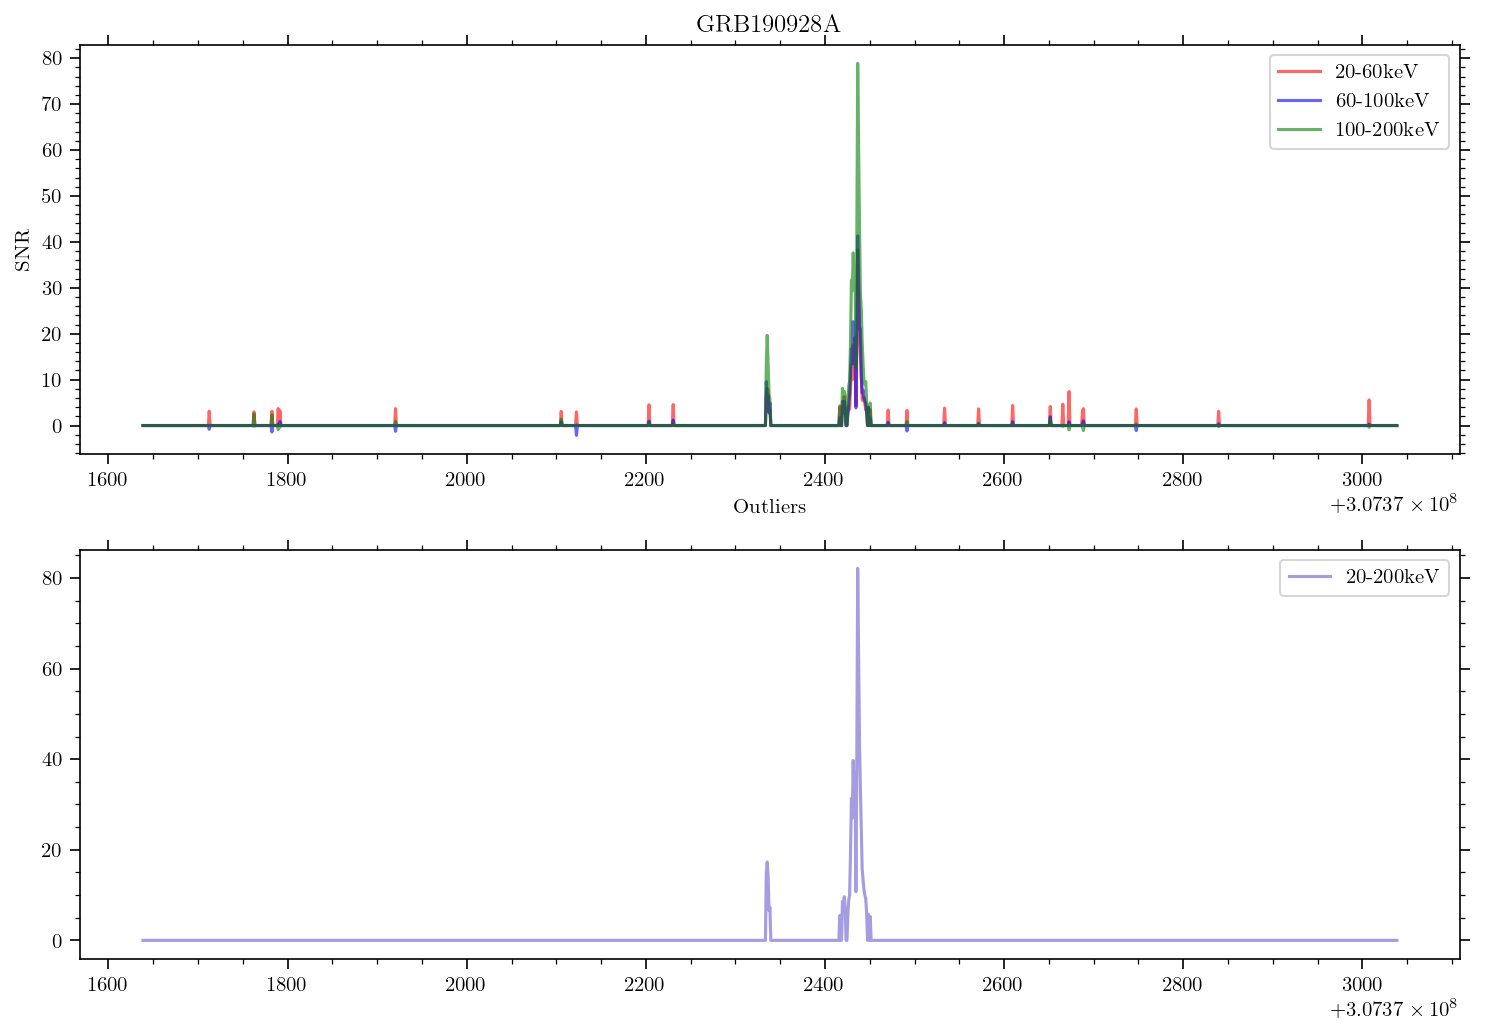

In [5]:
t, _ = pf.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB190928A/1s/3_bins/20-60/AS1A06_002T02_9000003206_21631cztM0_level2_quad_clean_Q0.lc", 1702)
grb = np.zeros_like(t['RATE'])
plt.figure(figsize=(10,7), dpi=150)
plt.subplot(2,1,1)
grb[outliers] = snr[0]
plt.plot(t['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
grb[outliers] = snr[1]
plt.plot(t['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
grb[outliers] = snr[2]
plt.plot(t['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
plt.title("GRB190928A")
plt.xlabel("Outliers")
plt.ylabel("SNR")
plt.legend()
plt.subplot(2,1,2)
grb[outliers] = 0
grb[outliers[grb_mask]] = grb_snr
plt.plot(t['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
snr, outliers, grb_mask, grb_snr = pf.find_grb("/home/ravioli/astro/ksp/grb/GRB210709A/1s", 363502145.0, sigma=2.5)

Master light curve already exists at /home/ravioli/astro/ksp/grb/GRB210709A/1s/master_lc
Requested energy bins already exist at /home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins


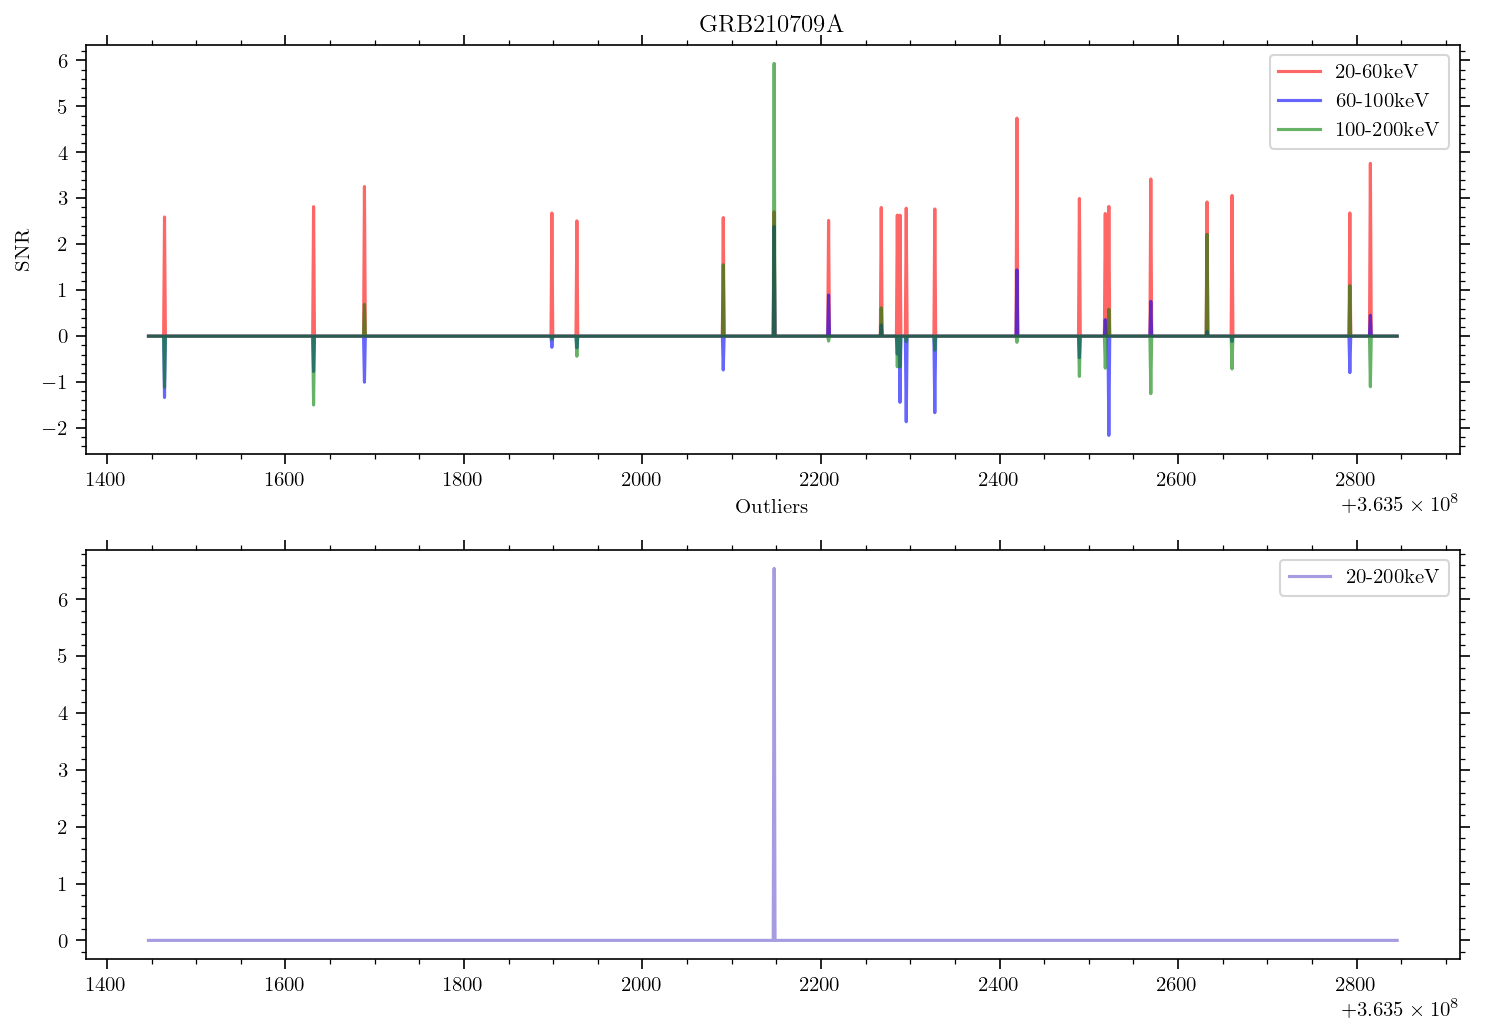

In [7]:
t, _ = pf.quadratic_detrend_trigger("/home/ravioli/astro/ksp/grb/GRB210709A/1s/3_bins/20-60/AS1A10_073T02_9000004522_31247cztM0_level2_quad_clean_Q0.lc", 3513)
grb = np.zeros_like(t['RATE'])
plt.figure(figsize=(10,7), dpi=150)
plt.subplot(2,1,1)
grb[outliers] = snr[0]
plt.plot(t['TIME'], grb, alpha=0.6, color='red', label='20-60keV')
grb[outliers] = snr[1]
plt.plot(t['TIME'], grb, alpha=0.6, color='blue', label='60-100keV')
grb[outliers] = snr[2]
plt.plot(t['TIME'], grb, alpha=0.6, color='green', label='100-200keV')
plt.title("GRB210709A")
plt.xlabel("Outliers")
plt.ylabel("SNR")
plt.legend()
plt.subplot(2,1,2)
grb[outliers] = 0
grb[outliers[grb_mask]] = grb_snr
plt.plot(t['TIME'], grb, alpha=0.6, color='slateblue', label='20-200keV')
plt.legend()
plt.tight_layout()
plt.show()